# Categoricals and Grid Search
## Sample Problem: Detecting Electrical Plugs in Amazon Marketplace Products
#### In this notebook, we will explore an Amazon dataset. In some marketplaces, ASINs having electrical plugs need to be accompanied by a compliance form. Thus it is desirable to identify ASINs which have an electrical plug.

__Dataset schema:__ 
- __ASIN__: Product ASIN
- __target_label:__ Binary field with values in {0,1}. A value of 1 show ASIN has a plug, otherwise 0.
- __ASIN_STATIC_ITEM_NAME:__ Title of the ASIN.
- __ASIN_STATIC_PRODUCT_DESCRIPTION:__ Description of the ASIN
- __ASIN_STATIC_GL_PRODUCT_GROUP_TYPE:__ GL information for the ASIN.
- __ASIN_STATIC_ITEM_PACKAGE_WEIGHT:__ Weight of the ASIN.
- __ASIN_STATIC_LIST_PRICE:__ Price information for the ASIN.
- __ASIN_STATIC_BATTERIES_INCLUDED:__ Information whether batteries are included along with the product.
- __ASIN_STATIC_BATTERIES_REQUIRED:__ Information whether batteries are required for using the product.
- __ASIN_STATIC_ITEM_CLASSIFICATION:__ Item classification of whether it is a standalone or bundle parent item etc

## 1. Reading the data
Let's read the dataset into a dataframe.

In [10]:
import pandas as pd

# import the datasets
df = pd.read_csv('C:\\Users\\solharsh\\Downloads\\Tabular Data MLU\\final_project\\final_project\\asin_product.csv',encoding= 'unicode_escape')

C:\Users\solharsh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,18,19,23,31,38,41,48,63,78,82,85,96,105) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Overall Statistics and Imputing:
We will look at number of rows, columns and simple statistics of the dataset.

In [37]:
df["ASIN_STATIC_ITEM_CLASSIFICATION"].unique()

array(['base_product', nan, 'variation_parent'], dtype=object)

In [38]:
# Print the first five rows
# NaN means missing data
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED,ASIN_STATIC_BATTERIES_REQUIRED,ASIN_STATIC_ITEM_CLASSIFICATION
0,B004U9MOWO,0,Master Lock 8 X 900 mm Chain Integrated 4 Digi...,Master Lock Street Flexium 900mm Integrated Co...,gl_sports,2.650000,16.66,False,False,base_product
1,B006OJWZMW,0,In Phase SRX-EQ 10 Band Parametric Equalizer w...,NaN,gl_wireless,1.680000,158.33,False,False,base_product
2,B00008VIJ4,0,Technics RPDJ1210 DJ Headphones - Silver,"Plated Connector:Gold, Connector Type:Headphon...",gl_home_entertainment,1.455036,NaN,False,False,base_product
3,B005433T4M,0,"Heartwarmers Coming Home Padded Lap Tray, 42 x...",NaN,gl_home,1.763680,12.49,False,NaN,base_product
4,B0073CN63Q,0,"Douceur D'Intérieur - 1600728, Curtain With E...",NaN,gl_home,2.292784,25.42,False,False,base_product


In [39]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61233 entries, 0 to 61232
Data columns (total 10 columns):
ASIN                                 61233 non-null object
target_label                         61233 non-null int64
ASIN_STATIC_ITEM_NAME                61233 non-null object
ASIN_STATIC_PRODUCT_DESCRIPTION      35261 non-null object
ASIN_STATIC_GL_PRODUCT_GROUP_TYPE    61233 non-null object
ASIN_STATIC_ITEM_PACKAGE_WEIGHT      61141 non-null float64
ASIN_STATIC_LIST_PRICE               45741 non-null float64
ASIN_STATIC_BATTERIES_INCLUDED       50058 non-null object
ASIN_STATIC_BATTERIES_REQUIRED       45229 non-null object
ASIN_STATIC_ITEM_CLASSIFICATION      61221 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 4.7+ MB


In [40]:
# This will print basic statistics for numerical columns
df.describe()

,target_label,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE
count,61233.000000,61141.000000,4.574100e+04
mean,0.036647,31.520023,1.475785e+02
std,0.187895,462.639041,1.664631e+04
min,0.000000,0.000000,1.160000e+00
25%,0.000000,1.520000,1.667000e+01
50%,0.000000,2.513244,3.291000e+01
75%,0.000000,5.555592,7.000000e+01
max,1.000000,29500.000000,3.560000e+06


Let's check our target distribution.

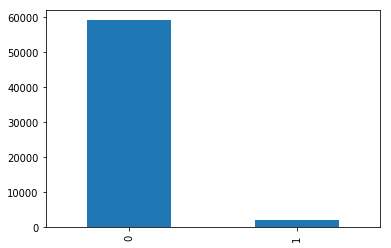

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

df['target_label'].value_counts().plot.bar()
plt.show()

We can see from the target plot above that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of "no plug" records but not many "plug" records.

In [42]:
df['ASIN_STATIC_LIST_PRICE'].value_counts(bins=10, sort=False)

(-3558.84, 356001.044]        45740
(356001.044, 712000.928]          0
(712000.928, 1068000.812]         0
(1068000.812, 1424000.696]        0
(1424000.696, 1780000.58]         0
(1780000.58, 2136000.464]         0
(2136000.464, 2492000.348]        0
(2492000.348, 2848000.232]        0
(2848000.232, 3204000.116]        0
(3204000.116, 3560000.0]          1
Name: ASIN_STATIC_LIST_PRICE, dtype: int64

We have an outlier data in the last bin. We will remove this data point below.

In [43]:
dropIndexes = df[df['ASIN_STATIC_LIST_PRICE'] > 3000000].index
df.drop(dropIndexes , inplace=True)

In [44]:
df['ASIN_STATIC_LIST_PRICE'].value_counts(bins=10, sort=False)

(-13.838999999999999, 1500.944]    45704
(1500.944, 3000.728]                  15
(3000.728, 4500.512]                   9
(4500.512, 6000.296]                   3
(6000.296, 7500.08]                    2
(7500.08, 8999.864]                    4
(8999.864, 10499.648]                  0
(10499.648, 11999.432]                 1
(11999.432, 13499.216]                 0
(13499.216, 14999.0]                   2
Name: ASIN_STATIC_LIST_PRICE, dtype: int64

Let's look at missing values for each column in our dataset.

In [45]:
df.isna().sum()

ASIN                                     0
target_label                             0
ASIN_STATIC_ITEM_NAME                    0
ASIN_STATIC_PRODUCT_DESCRIPTION      25972
ASIN_STATIC_GL_PRODUCT_GROUP_TYPE        0
ASIN_STATIC_ITEM_PACKAGE_WEIGHT         92
ASIN_STATIC_LIST_PRICE               15492
ASIN_STATIC_BATTERIES_INCLUDED       11175
ASIN_STATIC_BATTERIES_REQUIRED       16004
ASIN_STATIC_ITEM_CLASSIFICATION         12
dtype: int64

Let's fill the missing values for these columns.

In [46]:
# Numerical fields are imputed with mean values
df["ASIN_STATIC_ITEM_PACKAGE_WEIGHT"].fillna(df["ASIN_STATIC_ITEM_PACKAGE_WEIGHT"].mean(), inplace=True)
df["ASIN_STATIC_LIST_PRICE"].fillna(df["ASIN_STATIC_LIST_PRICE"].mean(), inplace=True)

# Categorical values are imputed with a placeholder value
df["ASIN_STATIC_BATTERIES_INCLUDED"].fillna("Missing", inplace=True)
df["ASIN_STATIC_BATTERIES_REQUIRED"].fillna("Missing", inplace=True)
df["ASIN_STATIC_ITEM_CLASSIFICATION"].fillna("Missing", inplace=True)

Let's check missing values one more time

In [47]:
df.isna().sum()

ASIN                                     0
target_label                             0
ASIN_STATIC_ITEM_NAME                    0
ASIN_STATIC_PRODUCT_DESCRIPTION      25972
ASIN_STATIC_GL_PRODUCT_GROUP_TYPE        0
ASIN_STATIC_ITEM_PACKAGE_WEIGHT          0
ASIN_STATIC_LIST_PRICE                   0
ASIN_STATIC_BATTERIES_INCLUDED           0
ASIN_STATIC_BATTERIES_REQUIRED           0
ASIN_STATIC_ITEM_CLASSIFICATION          0
dtype: int64

## 4. Processing Categorical Variables

Our categorical variables are __ASIN_STATIC_BATTERIES_INCLUDED__, __ASIN_STATIC_BATTERIES_REQUIRED__ and __ASIN_STATIC_ITEM_CLASSIFICATION__. It is a good idea to check the unique values for these columns.

In [48]:
df['ASIN_STATIC_BATTERIES_INCLUDED'].value_counts()

False      48123
Missing    11175
True        1934
Name: ASIN_STATIC_BATTERIES_INCLUDED, dtype: int64

In [49]:
df['ASIN_STATIC_BATTERIES_REQUIRED'].value_counts()

False      42415
Missing    16004
True        2813
Name: ASIN_STATIC_BATTERIES_REQUIRED, dtype: int64

In [50]:
df['ASIN_STATIC_ITEM_CLASSIFICATION'].value_counts()

base_product        61199
variation_parent       21
Missing                12
Name: ASIN_STATIC_ITEM_CLASSIFICATION, dtype: int64

Let's apply __one-hot-encoding__ to these three columns.

In [51]:
df = pd.get_dummies(df, columns=['ASIN_STATIC_BATTERIES_INCLUDED',
                                 'ASIN_STATIC_BATTERIES_REQUIRED',
                                 'ASIN_STATIC_ITEM_CLASSIFICATION',
                                 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'
                                ])

In [52]:
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED_False,ASIN_STATIC_BATTERIES_INCLUDED_True,ASIN_STATIC_BATTERIES_INCLUDED_Missing,ASIN_STATIC_BATTERIES_REQUIRED_False,...,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_office_product,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_pc,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_personal_care_appliances,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_pet_products,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_shoes,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_sports,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_toy,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_video_games,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_watch,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_wireless
0,B004U9MOWO,0,Master Lock 8 X 900 mm Chain Integrated 4 Digi...,Master Lock Street Flexium 900mm Integrated Co...,2.650000,16.660000,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,B006OJWZMW,0,In Phase SRX-EQ 10 Band Parametric Equalizer w...,NaN,1.680000,158.330000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,B00008VIJ4,0,Technics RPDJ1210 DJ Headphones - Silver,"Plated Connector:Gold, Connector Type:Headphon...",1.455036,69.750458,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,B005433T4M,0,"Heartwarmers Coming Home Padded Lap Tray, 42 x...",NaN,1.763680,12.490000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B0073CN63Q,0,"Douceur D'Intérieur - 1600728, Curtain With E...",NaN,2.292784,25.420000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 4. Training and test subsets
We will split our dataset into training (90%) and test (10%) subsets. 

In [53]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1, shuffle=True, random_state=23)

## 5. Fitting the classifier
We will use Sklearn's Decision Tree Classifier model here and apply Grid Search for hyper-parameter optimization. <br/>Let's first print the columns of our data table here.

In [54]:
columns = df.columns.tolist()
print(columns)

['ASIN', 'target_label', 'ASIN_STATIC_ITEM_NAME', 'ASIN_STATIC_PRODUCT_DESCRIPTION', 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT', 'ASIN_STATIC_LIST_PRICE', 'ASIN_STATIC_BATTERIES_INCLUDED_False', 'ASIN_STATIC_BATTERIES_INCLUDED_True', 'ASIN_STATIC_BATTERIES_INCLUDED_Missing', 'ASIN_STATIC_BATTERIES_REQUIRED_False', 'ASIN_STATIC_BATTERIES_REQUIRED_True', 'ASIN_STATIC_BATTERIES_REQUIRED_Missing', 'ASIN_STATIC_ITEM_CLASSIFICATION_Missing', 'ASIN_STATIC_ITEM_CLASSIFICATION_base_product', 'ASIN_STATIC_ITEM_CLASSIFICATION_variation_parent', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_apparel', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_automotive', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_baby_product', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_beauty', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_biss', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_book', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_camera', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_drugstore', 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE_gl_electronics', 'ASIN_STATIC_GL_PRODUCT_GROUP_T

We will __NOT__ use __'ASIN', 'ASIN_STATIC_ITEM_NAME', 'ASIN_STATIC_PRODUCT_DESCRIPTION'__ fields. The rest will be used to fit our decision tree. 'ASIN_STATIC_ITEM_NAME', 'ASIN_STATIC_PRODUCT_DESCRIPTION' fields are text fields. We need to apply text processing techniques for these fields. 

In [55]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# We will skip the 'ASIN', 'target_label', 'ASIN_STATIC_ITEM_NAME', 'ASIN_STATIC_PRODUCT_DESCRIPTION' and keep the rest
X_train = train_data[columns[4:]].values
y_train = train_data['target_label'].values

print("Training data shape:", X_train.shape)
print("Training label shape:", y_train.shape)

param_grid={'max_depth': [50, 75, 100, 125, 150, 200, 250], 
            'min_samples_leaf': [5, 10, 15, 25, 30],
            'min_samples_split': [2, 5, 15, 25, 30, 45, 50]
           }

# Here, we will use class_weight parameter. This will put more weight to smaller class during training.
dt = DecisionTreeClassifier(class_weight = 'balanced')

grid_search = GridSearchCV(dt, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors 
                          )

grid_search.fit(X_train, y_train)

Training data shape: (55108, 40)
Training label shape: (55108,)
Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed:  5.9min finished


CPU times: user 4.97 s, sys: 366 ms, total: 5.34 s
Wall time: 5min 51s


In [56]:
grid_search.best_params_

{'max_depth': 150, 'min_samples_leaf': 5, 'min_samples_split': 5}

## 6. Testing
Let's see how the classifier performs with "unseen" data (our test data). We will use the predict() function this time.

In [57]:
# Let's get the input and output data for testing the classifier
X_test = test_data[columns[4:]].values
y_test = test_data['target_label'].values

y_pred = grid_search.predict(X_test)

We will use Sklearn's metrics functions to see the results.

__Confusion matrix:__ The diagonals show us correct classifications. Each row and column belongs to a class (plug or no plug). The first column and row correspond to "no plug" case, the second column-rows are "plug" case.

In [58]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[5095  825]
 [ 144   60]]


When we look at the confusion matrix, it is better than our previous KNN model in terms of getting more "plug" cases correctly (60).

Let's look at the __classification report__ and __accuracy__ below.

In [59]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      5920
           1       0.07      0.29      0.11       204

   micro avg       0.84      0.84      0.84      6124
   macro avg       0.52      0.58      0.51      6124
weighted avg       0.94      0.84      0.89      6124

Accuracy: 0.8417700849118224


As we are dealing with an imbalanced dataset, accuracy can be a misleading metric. We should make a class based perfomance assessment.


The small or underrepresented class performance improved with this model, but there is still a lot of room for improvement.